In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import digamma, betainc, beta

In [19]:
def linspace(x0, x1, n):
    return x0 + (x1 - x0) * (np.arange(n) + 0.5) / n

def compute_recall_lb(x, L1):
    return np.maximum(1 + L1 / np.log(x), 0)
    
def compute_precision_lb(x, L0, L1):
    z = - compute_recall_lb(x, L1) * np.log(1 - x)
    return z / (L0 + z)

def compute_precision_at_recall_lb(R, L0, L1):
    x_min = np.exp(-L1 / (1 - R))
    z = - R * np.log(1 - x_min)
    return z / (L0 + z)

def compute_average_precision_lb(Ltot, n_recall, n_frac):
    frac = linspace(0, 1, n_frac)
    recall = linspace(0, 1, n_recall)
    Ltot = Ltot[:, None, None]
    frac = frac[None, :, None]
    recall = recall[None, None, :]
    L0 = Ltot * frac
    L1 = Ltot * (1 - frac)
    precision_at_recall_lb = compute_precision_at_recall_lb(recall, L0, L1)
    return np.amin(np.mean(precision_at_recall_lb, -1), -1)

def compute_sample_statistics(k_sample, x_sample):
    assert k_sample.ndim == 1
    assert k_sample.shape == x_sample.shape
    sort_index = np.flip(np.argsort(x_sample, stable=True))
    x_sample = x_sample[sort_index]
    k_sample = k_sample[sort_index]
    n_true = np.sum(k_sample)
    n_true_positive = np.cumsum(k_sample)
    n_positive = 1 + np.arange(len(k_sample))
    recall = n_true_positive / n_true
    precision = n_true_positive / n_positive
    L0 = - np.sum(np.log(np.where(k_sample, 1, np.maximum(1 - x_sample, 1e-128)))) / n_true
    L1 = - np.sum(np.log(np.where(k_sample, np.maximum(x_sample, 1e-128), 1))) / n_true
    ap = recall[0] * precision[0] + np.sum(
        (precision[1:] + precision[:-1]) / 2 * (recall[1:] - recall[:-1]))
    return {
        'threshold': x_sample,
        'recall': recall,
        'precision': precision,
        'L0': L0,
        'L1': L1,
        'Ltot': L0 + L1,
        'ap': ap,
    }

def get_sample(n_sample, p1, alpha0, beta0, alpha1, beta1, rng):
    k_sample = rng.uniform(size=n_sample) > p1
    x_sample = np.where(
        k_sample,
        rng.beta(alpha1, beta1, size=n_sample),
        rng.beta(alpha0, beta0, size=n_sample),
    )
    return (k_sample, x_sample)

def compute_population_statistics(p1, alpha0, beta0, alpha1, beta1, nx):
    p0 = 1 - p1
    L0 = p0 / p1 * (digamma(alpha0 + beta0) - digamma(beta0))
    L1 = digamma(alpha1 + beta1) - digamma(alpha1)
    x = linspace(0, 1, nx)
    recall = 1 - betainc(alpha1, beta1, x)
    precision = 1 / (1 + p0 / p1 * (1 - betainc(alpha0, beta0, x)) /  recall)
    d_recall =  1 / beta(alpha1, beta1) * np.power(x, alpha1 - 1) * np.power(1 - x, beta1 - 1)
    ap = np.mean(precision * d_recall, -1)
    return {
        'threshold': x,
        'recall': recall,
        'precision': precision,
        'L0': L0,
        'L1': L1,
        'Ltot': L0 + L1,
        'ap': ap,
    }

def compute_threshold(counts):
    assert counts.shape[-1] == 2
    return counts[..., 0] / np.sum(counts, -1)

def combine_optimal_threshold(counts, new_counts):
    """Combine thresholds
    counts: [..., n_thresholds, left/right]
    new_counts: [..., left / right]
    """
    new_counts = new_counts[..., None, :]
    sum_counts = counts + new_counts
    x0 = compute_threshold(counts)
    x1 = compute_threshold(new_counts)
    x2 = compute_threshold(sum_counts)
    return np.concatenate([
        np.where(x2[..., None] < x0[..., None], sum_counts, counts),
        np.where(
            x1[..., -1:, None] > x2[..., -1:, None], 
            new_counts[..., -1:, :],
            sum_counts[..., -1:, :],
        )],
        axis=-2
    )

def compute_optimal_thresholds(counts):
    """Compute thresholds
    counts: [..., n_thresholds, left/right]
    """
    counts = np.array(counts)
    result = counts[...,:1, :]
    for i in range(1, counts.shape[-2]):
        result = combine_optimal_threshold(result, counts[...,i, :])
    return compute_threshold(result)


def make_n_flips_sample(n0, counts, n1):
    """Make n flips sample
    counts: [n_flips, left/right]
    """
    counts = np.array(counts)
    thresholds = compute_optimal_thresholds(counts)
    k_sample = np.concatenate([
        np.concatenate([
            np.ones(counts[i, 0], dtype=bool),
            np.zeros(counts[i, 1], dtype=bool),
        ])
        for i in range(counts.shape[0])
    ])
    k_sample = np.concatenate([
        np.zeros(n0, dtype=bool),
        k_sample,
        np.ones(n1, dtype=bool),
    ])
    x_sample = np.concatenate([
        np.concatenate([
            np.full(counts[i, 0], thresholds[i]),
            np.full(counts[i, 1], thresholds[i])
        ])
        for i in range(counts.shape[0])
    ])
    x_sample = np.concatenate([
        np.zeros(n0),
        x_sample,
        np.ones(n1)
    ])
    return k_sample, x_sample

def compute_loss_and_average_precision_one_flip(n0, n1):
    loss = -np.log(n1 / (n0 + n1)) - n0 / n1 * np.log(n0 / (n0 + n1))
    ap = (1 - 1 / (2 * (n0 + n1)) - 
            n0 / n1 * (digamma(n0 + n1 + 1) - digamma(n0 + 1)))
    return loss, ap

In [ ]:
n_sample = 1 << 10
rng = np.random.default_rng(0)
result = []
for i in range(n_sample):
    k_sample, x_sample = get_sample(
        n_sample=rng.integers(1, 10),
        p1=0.5,
        alpha0=1.0,
        beta0=1.0,
        alpha1=1.0,
        beta1=1.0,
        rng=rng,
    )
    if np.sum(k_sample) == 0:
        continue
    stats = compute_sample_statistics(k_sample, x_sample)
    result.append((stats['L0'] + stats['L1'], stats['ap']))
sample = np.array(result)


In [20]:
table = []
for n0, m01, m00, n1 in itertools.product(
    range(0, 5), 
    range(1, 30), 
    range(1, 5),
    range(0, 5),
    ):
    stats = compute_sample_statistics(*make_n_flips_sample(n0, [[m01, m00]], n1))
    table.append((n0, m01, m00, n1, stats['L0'], stats['ap']))
table = pd.DataFrame(table, columns=['n0', 'm01', 'm00', 'n1', 'L0', 'ap'])

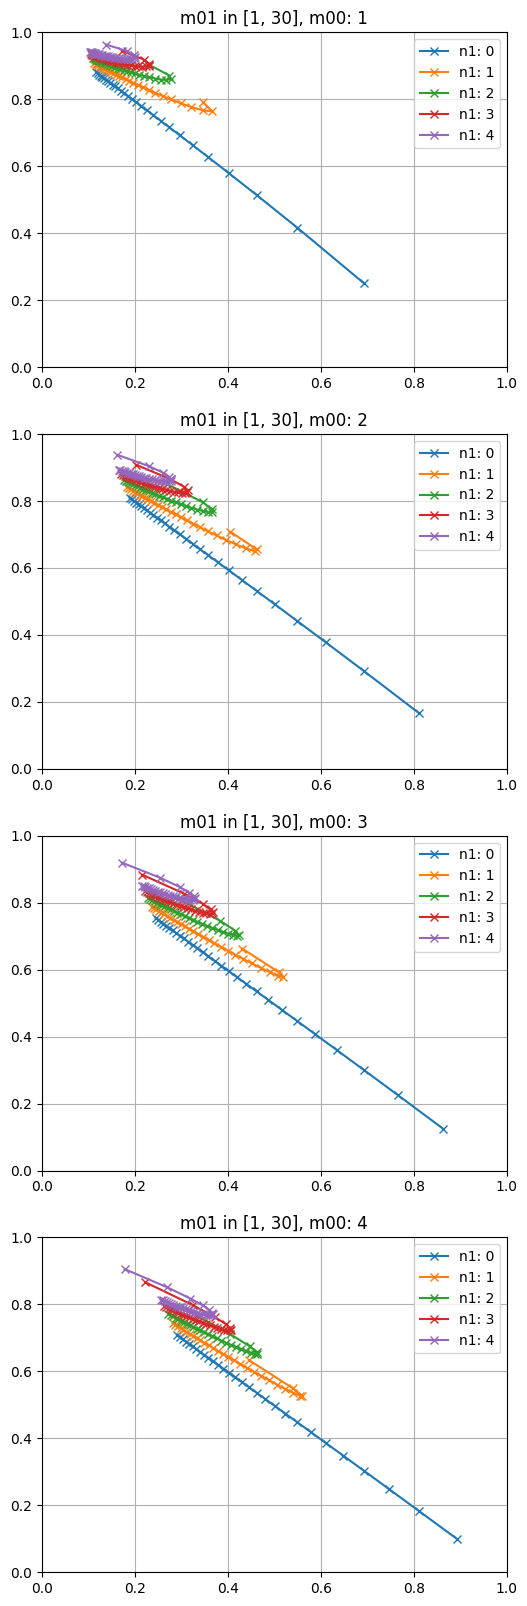

In [21]:
rng = np.random.default_rng(0)
figure, axes = plt.subplots(4, 1, figsize=(6, 20))
subset = table[table['n0'] == 0]
for i, axes_i in enumerate(axes):
    key1 = 'm00'; value_i = i + 1
    subset_i = subset[subset[key1] == value_i]
    axes_i.set_title(f"m01 in [1, 30], {key1}: {value_i}")
    key2 = 'n1'
    for key2_value, group in subset_i.groupby(key2):
        noise = rng.normal(0, 0.00, len(group['ap']))
        axes_i.plot(group['L0'], group['ap'] + noise, marker='x', label=f"{key2}: {key2_value}")
    axes_i.legend()
    axes_i.grid()
    axes_i.set_xlim(0, 1)
    axes_i.set_ylim(0, 1)
plt.show(figure)
plt.close(figure)

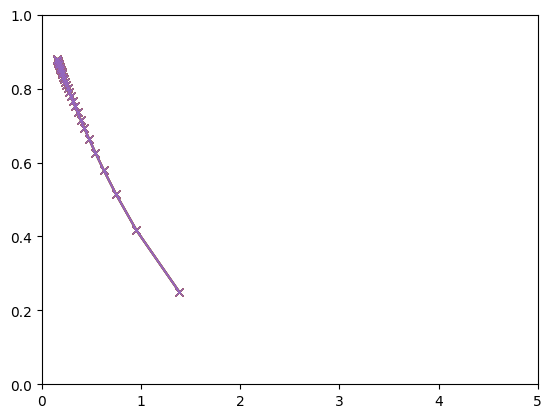

In [12]:
# sample1 = np.load('sample.npy')
# n1 = linspace(0, 100, 1024)
figure, axes = plt.subplots(1, 1)
# axes.scatter(*np.transpose(sample1), s=0.5)
# for n0 in range(5):
#     axes.plot(*compute_loss_and_average_precision_one_flip(n0, n1))
for sample in samples:
    axes.plot(*np.transpose(sample), marker='x')
axes.set_xlim(0, 5)
axes.set_ylim(0, 1)
plt.show(figure)
plt.close(figure)

threshold: [0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697]
recall: [0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875 1.     ]
precision: [0.         0.5        0.66666667 0.75       0.8        0.83333333
 0.85714286 0.875      0.88888889 0.9        0.90909091 0.91666667
 0.92307692 0.92857143 0.93333333 0.9375     0.94117647 0.94444444
 0.94736842 0.95       0.95238095 0.95454545 0.95652174 0.95833333
 0.96       0.96153846 0.96296296 0.96428571 0.96551724 0.96666667


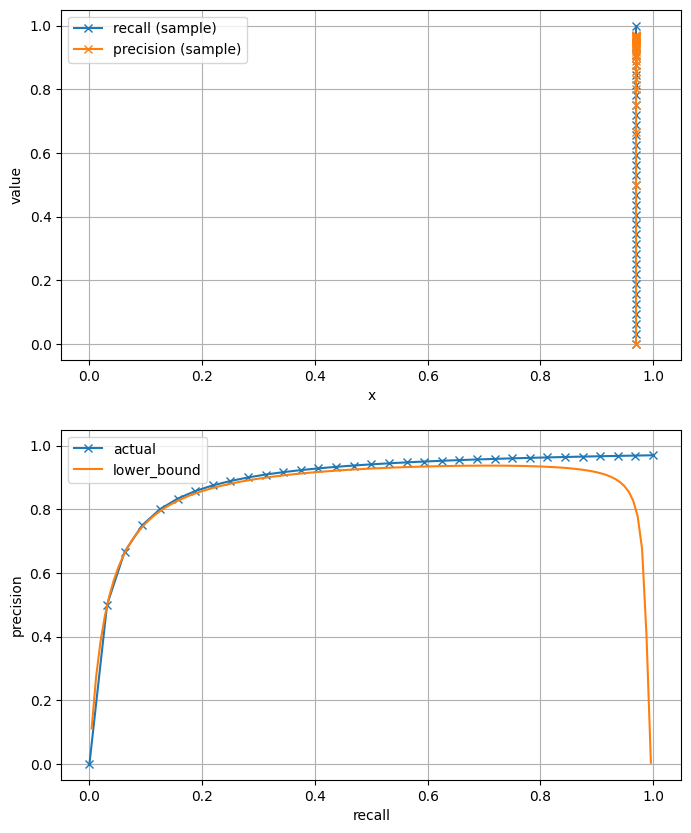

In [77]:
rng = np.random.default_rng(0)
params = {
    "p1": 0.5,
    "alpha0": 1.0, 
    "beta0": 3.0,
    "alpha1": 3.0, 
    "beta1": 1.0,
}
# k_sample, x_sample = get_sample(
#     n_sample=10000,
#     rng=np.random.default_rng(0),
#     **params
# )
k_sample, x_sample = make_n_flips_sample(0, [[32, 1]], 0)
recall_values = linspace(0, 1, 128)
sample_stats = compute_sample_statistics(k_sample, x_sample)
for key, value in sample_stats.items():
    print(f"{key}: {value}")
population_stats = compute_population_statistics(nx=128, **params)
precision_at_recall_lb = compute_precision_at_recall_lb(recall_values, sample_stats['L0'], sample_stats['L1'])
# for key in ['L0', 'L1', 'ap']:
#     print(f'{key}: {sample_stats[key]:.3f} {population_stats[key]:.3f}')
figure, (axes_threshold, axes_recall) = plt.subplots(2,1, figsize=(8, 10))
# axes_hist.hist(x_sample[k_sample], histtype='step', bins=np.linspace(0, 1, 20))
# axes_hist.hist(x_sample[~k_sample], histtype='step', bins=np.linspace(0, 1, 20))
axes_threshold.plot(sample_stats['threshold'], sample_stats['recall'], 
                    label='recall (sample)', marker='x')
axes_threshold.plot(sample_stats['threshold'], sample_stats['precision'], 
                    label='precision (sample)', marker='x')
# axes_threshold.plot(population_stats['threshold'], population_stats['recall'], label='recall (pop)')
# axes_threshold.plot(population_stats['threshold'], population_stats['precision'], label='recall (pop)')
axes_threshold.set_xlim(-0.05, 1.05)
axes_threshold.set_ylim(-0.05, 1.05)
axes_threshold.set_xlabel('x')
axes_threshold.set_ylabel('value')
axes_threshold.legend()
axes_threshold.grid()
axes_recall.plot(sample_stats['recall'], sample_stats['precision'], 
                 label='actual', marker='x')
axes_recall.plot(recall_values, precision_at_recall_lb, label='lower_bound')
axes_recall.set_xlim(-0.05, 1.05)
axes_recall.set_ylim(-0.05, 1.05)
axes_recall.grid()
axes_recall.set_xlabel('recall')
axes_recall.set_ylabel('precision')
axes_recall.legend()
plt.show(figure)


In [ ]:
L0 = linspace(0, 0.5, 128)
L1 = linspace(0, 0.5, 128)
R = linspace(0, 1, 128)
L0 = L0[:, None, None]
L1 = L1[None, :, None]
R = R[None, None, :]
p_lb = compute_precision_at_recall_lb(R, L0, L1)
ap_lb = np.mean(p_lb, axis=2)
figure, axes = plt.subplots(1, 1)
axes.contour(
    ap_lb, levels=np.linspace(0,1,11),
    origin='lower',
    extent=(0, L1[0, -1, 0], 0, L0[-1, 0, 0])
)
axes.set_xlabel('L1')
axes.set_ylabel('L0')
plt.show(figure)

In [229]:
def threshold(n1, n2):
    return n1 / (n1 + n2)

def combined_thresholds(n1, n2, n3, n4):
    x1 = threshold(n1, n2)
    x2 = threshold(n3, n4)
    x3 = threshold(n1 + n3, n2 + n4)
    return np.minimum(x1, x3), np.maximum(x2, x3)

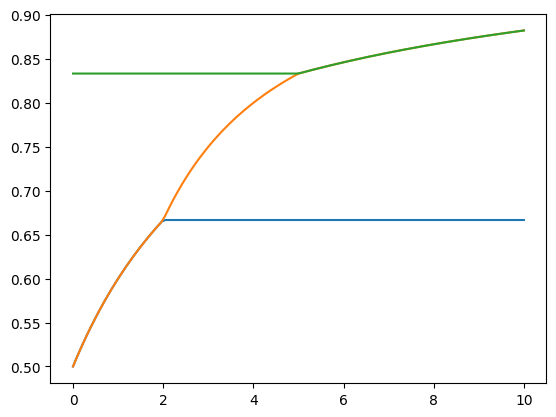

In [6]:
n_plot = 128
n1 = np.linspace(0, 10, n_plot)
counts = np.stack([
    np.stack([np.full(n_plot, 2), np.full(n_plot, 1)], -1),
    np.stack([n1, np.full(n_plot, 1)], -1),
    np.stack([np.full(n_plot, 5), np.full(n_plot, 1)], -1),
], -2)
thresholds = compute_optimal_thresholds(counts)
figure, axes = plt.subplots(1, 1)
for i in range(thresholds.shape[-1]):
    axes.plot(n1, thresholds[:, i])
plt.show(figure)
plt.close(figure)